
# **Livrable 1 – Modélisation du Time-Dependent Vehicle Routing Problem (TDVRP)**  
### Projet ADEME – Mobilité Multimodale Intelligente  
**Équipe :** CesiCDP – Groupe de Louka, Evan, Mael, Hugo  
**Date :** Octobre 2025  
---



## 1. Introduction et Contexte

Depuis les années 90, il y a eu une prise de conscience mondiale de la nécessité de réduire la consommation d'énergie et les émissions de gaz à effet de serre. Les premiers engagements sont apparus lors du **Protocole de Kyoto (1997)**, suivi d'autres plus ambitieux comme la **division par 4 des émissions d’ici 2050 en France**.  

Dans ce contexte, **l’ADEME (Agence de l’Environnement et de la Maîtrise de l’Énergie)** a lancé un appel à manifestation d’intérêt pour promouvoir des **solutions de mobilité innovantes** et plus écologiques.  

Notre équipe **CesiCDP** s’inscrit dans cette démarche à travers une étude sur la **mobilité multimodale intelligente**. Nous avons choisi de nous concentrer sur l’**optimisation des tournées de livraison**, un enjeu central de la logistique moderne.  

Nous modélisons ici un problème de **gestion de tournées (Vehicle Routing Problem - VRP)** en intégrant une **contrainte de trafic dynamique**, pour mieux représenter les conditions de circulation réelles. Notre flotte de véhicules est **thermique et homogène**, ce qui accentue l’importance de la réduction du temps de trajet et de la consommation de carburant.



## 2. Problématique et Objectif

Le **problème de base** consiste à déterminer une tournée reliant un ensemble de villes (ou clients) à partir d’un dépôt, en revenant au point de départ, tout en minimisant le **coût total de déplacement**.

Notre objectif est de résoudre une version plus réaliste : le **Time-Dependent Vehicle Routing Problem (TDVRP)**, dans lequel les **coûts de déplacement dépendent du temps** à cause du **trafic routier**.

Ainsi, la distance entre deux points $i$ et $j$ n’est plus constante mais devient une fonction du temps :

$$
c_{ij}(t) = c_{ij} \times f_{ij}(t)
$$

où :
- $c_{ij}$ représente le coût de base (distance ou durée moyenne entre $i$ et $j$),  
- $f_{ij}(t)$ est un facteur d’augmentation dû au trafic à l’instant $t$ (par exemple $f_{ij}(t) = 1.5$ en heure de pointe).

Le but est de trouver la tournée minimisant le **temps total de parcours**, tout en tenant compte de ces variations temporelles.


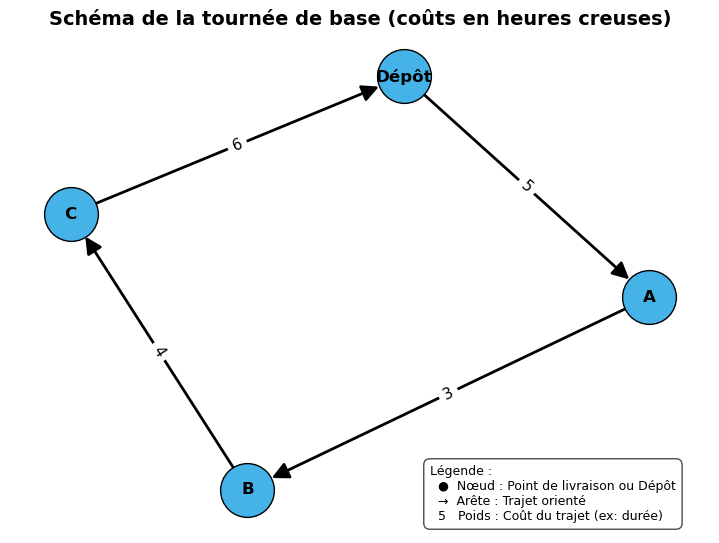

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

# --- 1. Définition des données ---
base_edges = [
    ("Dépôt", "A", 5),
    ("A", "B", 3),
    ("B", "C", 4),
    ("C", "Dépôt", 6)
]

# --- 2. Création du graphe ---
G = nx.DiGraph()
for u, v, w in base_edges:
    G.add_edge(u, v, weight=w)

# --- 3. Paramètres de style ---
style = {
    "node_color": "#45B3E7",
    "node_size": 1500,
    "node_border_color": "black",
    "arrow_size": 25,
    "edge_width": 2.0,
    "font_size_nodes": 12,
    "font_size_edges": 11,
    "font_weight": "bold"
}

# --- 4. Visualisation ---
pos = nx.spring_layout(G, seed=42)
weights = nx.get_edge_attributes(G, "weight")

plt.figure(figsize=(7, 5))

nx.draw(
    G, 
    pos, 
    with_labels=True, 
    node_color=style["node_color"], 
    node_size=style["node_size"],
    edgecolors=style["node_border_color"],
    arrowsize=style["arrow_size"],
    width=style["edge_width"],
    font_size=style["font_size_nodes"],
    font_weight=style["font_weight"]
)

nx.draw_networkx_edge_labels(
    G, 
    pos, 
    edge_labels=weights,
    font_size=style["font_size_edges"]
)

plt.title("Schéma de la tournée de base (coûts en heures creuses)", fontsize=14, weight='bold')

# --- 5. Ajout de la légende ---
# On crée une zone de texte pour décrire les éléments du graphe.
legend_text = (
    "Légende :\n"
    "  ●  Nœud : Point de livraison ou Dépôt\n"
    "  →  Arête : Trajet orienté\n"
    "  5   Poids : Coût du trajet (ex: durée)"
)

# On place cette zone de texte en bas à gauche de la figure.
plt.text(
    0.6, 0.02, # Position (x, y) en coordonnées relatives à la figure
    legend_text,
    transform=plt.gcf().transFigure, # Utiliser le système de coordonnées de la figure
    fontsize=9,
    verticalalignment='bottom', # Aligner le texte par le bas
    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7) # Boîte de style
)

# Afficher le graphique final
plt.show()


## 3. Contrainte supplémentaire : Trafic dynamique

Nous intégrons la contrainte de **trafic variable dans le temps**, qui transforme notre VRP classique en **TDVRP (Time-Dependent Vehicle Routing Problem)**.

En effet, dans la réalité, la durée d’un trajet entre deux points dépend fortement du moment de la journée :  
- plus longue aux heures de pointe,  
- plus courte en heures creuses.

Le coût de déplacement $c_{ij}(t)$ devient donc **fonction du temps**.

Cette contrainte modifie la structure du graphe : les arêtes ont désormais des poids **dynamiques**, dépendant du temps courant du trajet.


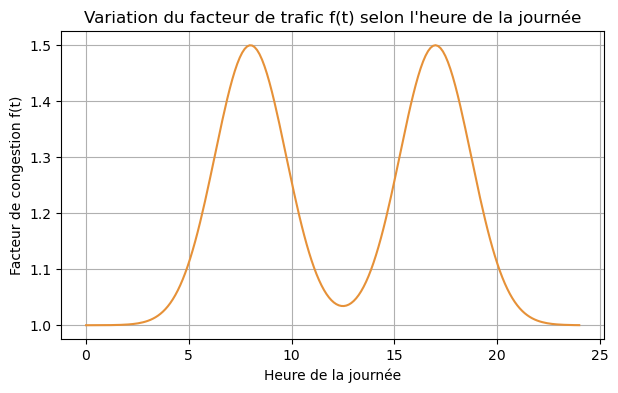

In [17]:

import numpy as np

t = np.linspace(0, 24, 200)
f_t = 1 + 0.5 * np.exp(-((t - 8)**2)/6) + 0.5 * np.exp(-((t - 17)**2)/6)

plt.figure(figsize=(7,4))
plt.plot(t, f_t, color="#e69138")
plt.title("Variation du facteur de trafic f(t) selon l'heure de la journée")
plt.xlabel("Heure de la journée")
plt.ylabel("Facteur de congestion f(t)")
plt.grid(True)
plt.show()


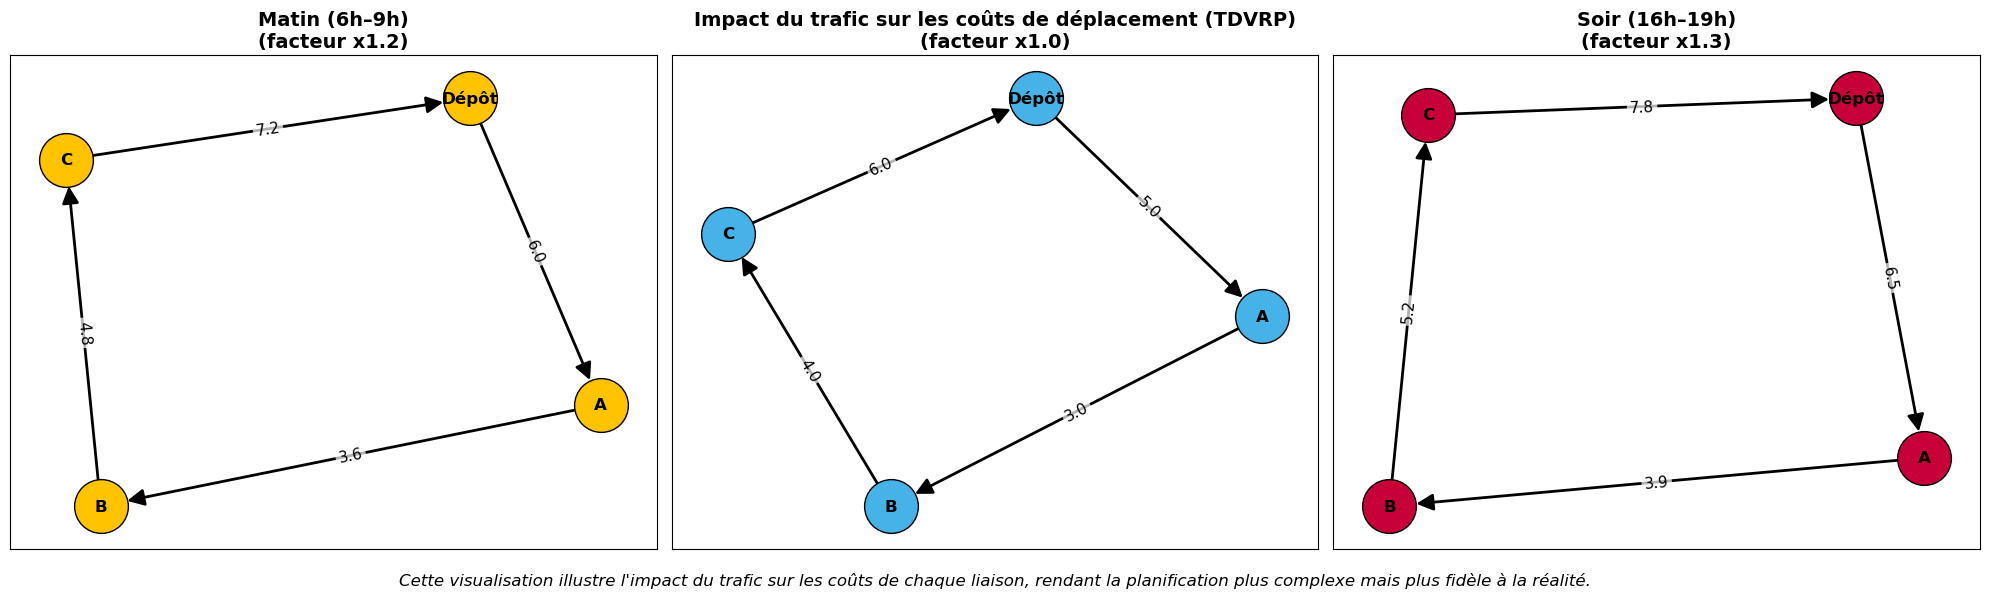

In [18]:
import matplotlib.pyplot as plt
import networkx as nx

# --- 1. Définition des données et des périodes ---

# Dictionnaire des périodes avec leurs facteurs de trafic
periods_data = {
    "Matin (6h–9h)": {"factor": 1.2, "color": "#FFC300"},  # Jaune/Or pour le matin
    "Journée (9h–16h)": {"factor": 1.0, "color": "#45B3E7"},  # Bleu clair pour la journée
    "Soir (16h–19h)": {"factor": 1.3, "color": "#C70039"}   # Rouge/Bordeaux pour le soir
}

# Liaisons de base (arêtes) avec leurs coûts sans trafic
# Format: (noeud_depart, noeud_arrivee, cout_base)
base_edges = [
    ("Dépôt", "A", 5),
    ("A", "B", 3),
    ("B", "C", 4),
    ("C", "Dépôt", 6)
]

# --- 2. Paramètres de style pour le graphique ---

style_params = {
    "node_size": 1500,
    "node_border_color": "black",
    "arrow_size": 25,
    "edge_width": 2.0,
    "font_size_nodes": 12,
    "font_size_edges": 11,
    "font_weight": "bold",
    "edge_font_color": "black"
}

# --- 3. Création de la visualisation ---

# Création de la figure qui contiendra nos 3 graphiques
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Titre principal qui sera placé au-dessus du graphique du milieu
main_title = "Impact du trafic sur les coûts de déplacement (TDVRP)"

# Boucle pour créer chaque graphique un par un
for i, (ax, (period_name, data)) in enumerate(zip(axes, periods_data.items())):
    factor = data["factor"]
    node_main_color = data["color"]
    
    # Création d'un graphe orienté pour cette période
    G = nx.DiGraph()
    for u, v, w in base_edges:
        # Ajout de chaque liaison avec le coût ajusté par le facteur de trafic
        G.add_edge(u, v, weight=w * factor)
        
    # Positionnement des noeuds (seed=42 pour que la disposition soit toujours la même)
    pos = nx.spring_layout(G, seed=42)
    
    # Récupération des poids calculés pour les afficher
    edge_weights = nx.get_edge_attributes(G, "weight")
    
    # Dessin des noeuds
    nx.draw_networkx_nodes(G, pos, ax=ax, 
                           node_size=style_params["node_size"],
                           node_color=node_main_color,
                           edgecolors=style_params["node_border_color"])

    # Dessin des arêtes (liaisons) et des flèches
    nx.draw_networkx_edges(G, pos, ax=ax,
                           width=style_params["edge_width"],
                           arrowsize=style_params["arrow_size"],
                           arrowstyle='-|>',
                           node_size=style_params["node_size"])
    
    # Dessin des étiquettes des noeuds (Dépôt, A, B, C)
    nx.draw_networkx_labels(G, pos, ax=ax, 
                            font_size=style_params["font_size_nodes"],
                            font_weight=style_params["font_weight"])

    # Dessin des étiquettes des coûts sur les liaisons
    nx.draw_networkx_edge_labels(
        G, pos, ax=ax,
        edge_labels={k: f"{v:.1f}" for k, v in edge_weights.items()},
        font_size=style_params["font_size_edges"],
        font_color=style_params["edge_font_color"],
        # Cette boîte semi-transparente rend le texte lisible partout
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
    )

    # Définition du titre de chaque sous-graphique
    if i == 1:  # Graphique du milieu
        ax.set_title(f"{main_title}\n(facteur x{factor:.1f})", fontsize=14, weight='bold')
    else:  # Graphiques de gauche et de droite
        ax.set_title(f"{period_name}\n(facteur x{factor:.1f})", fontsize=14, weight='bold')

# --- 4. Affichage final ---

# Ajout du texte descriptif en bas, comme dans l'image originale
fig.text(0.5, 0.01, 
         "Cette visualisation illustre l'impact du trafic sur les coûts de chaque liaison, rendant la planification plus complexe mais plus fidèle à la réalité.", 
         ha='center', va='bottom', fontsize=12, style='italic')

# Ajuste automatiquement la mise en page pour que tout soit bien visible
plt.tight_layout(rect=[0, 0.05, 1, 1]) # rect laisse de la place pour le texte en bas

plt.show()


## 4. Modélisation mathématique

Soit :  
- $G = (V, E)$ un graphe orienté,  
- $V = \{0, 1, ..., n\}$ l’ensemble des sommets (0 représentant le dépôt),  
- $E$ l’ensemble des arêtes reliant ces sommets,  
- $c_{ij}(t)$ le coût (temps de trajet) entre $i$ et $j$ à l’instant $t$.

Variables de décision :  
$$
x_{ij} = 
\begin{cases}
1 & \text{si l’arête } (i,j) \text{ est empruntée} \\
0 & \text{sinon}
\end{cases}
$$

Objectif :  
Minimiser la durée totale de la tournée :  
$$
\min \sum_{i \in V} \sum_{j \in V} c_{ij}(t_i) \times x_{ij}
$$

Sous contraintes :  
1. Chaque client est visité une seule fois :  
$$
\sum_{j \in V} x_{ij} = 1, \quad \forall i \in V \setminus \{0\}
$$
2. Conservation du flux :  
$$
\sum_{i \in V} x_{ij} = \sum_{k \in V} x_{jk}, \quad \forall j \in V
$$
3. Retour obligatoire au dépôt :  
$$
\sum_{i \in V} x_{i0} = 1
$$


## 5. Étude de complexité

Le **VRP classique** est un problème **NP-difficile**, car il généralise le célèbre **Problème du Voyageur de Commerce (TSP)**. Cela signifie qu'il n'existe pas d'algorithme connu capable de trouver la solution optimale rapidement pour de grandes instances.

L'ajout de la **contrainte de trafic (TDVRP)** rend le problème encore plus complexe pour deux raisons majeures :

**1. Le problème devient dynamique :**
   - Dans un VRP classique, le temps de trajet entre deux points est fixe. On peut donc travailler sur une carte "statique".
   - Dans le TDVRP, le temps de trajet $c_{ij}(t)$ change constamment en fonction de l'heure. La "meilleure" route à prendre à 8h du matin n'est pas forcément la même à 14h. La solution optimale ne dépend donc plus seulement de l'**ordre** des visites, mais aussi du **moment** où elles sont effectuées.

**2. L'espace de recherche explose :**
   - Pour trouver la meilleure tournée dans un VRP classique, il faut comparer les différentes séquences possibles de clients (ex: `A→B→C` vs `B→A→C`).
   - Pour le TDVRP, il faut non seulement comparer ces séquences, mais aussi évaluer chaque séquence en fonction de son **heure de départ**. Une tournée qui part à 7h du matin n'aura pas le même coût total que la même tournée qui part à 9h. L'heure d'arrivée à un client influence directement le coût du trajet vers le client suivant, créant une cascade de dépendances.

En résumé, alors que le VRP cherche le meilleur chemin dans l'espace, le TDVRP cherche le meilleur chemin dans l'**espace-temps**. Cette dimension supplémentaire augmente exponentiellement le nombre de possibilités à évaluer.

**Conclusion :**

Le TDVRP est non seulement **NP-difficile**, mais il est structurellement plus complexe que le VRP classique. La nécessité de gérer à la fois un problème de séquençage et de planification horaire rend les méthodes exactes impraticables, même pour des problèmes de taille modeste. Cela justifie le recours à des algorithmes approchés (métaheuristiques) pour obtenir de bonnes solutions.


## 6. Conclusion

Dans ce premier livrable, nous avons :
- Présenté le contexte du projet ADEME et notre rôle dans la mobilité intelligente ;  
- Reformulé le **problème de tournée de véhicules dépendant du temps (TDVRP)** ;  
- Proposé une **modélisation formelle et mathématique** du problème ;  
- Étudié la **complexité théorique**, qui reste NP-difficile.

La prochaine étape consistera à concevoir et implémenter une **métaheuristique** adaptée (par exemple **Recuit Simulé**, **Tabu Search** ou **ALNS**) capable de traiter des instances de taille réaliste (supérieur à 1000 clients).



## 7. Références bibliographiques

- Analyse de la complexité :
https://fr.wikipedia.org/wiki/Analyse_de_la_complexit%C3%A9_des_algorithmes

- Théorie des Graphes :
https://fr.wikipedia.org/wiki/Th%C3%A9orie_des_graphes

- Problème du voyageur de commerce : 
https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce

- P, NP et les classes : 
https://www.geeksforgeeks.org/dsa/types-of-complexity-classes-p-np-conp-np-hard-and-np-complete
